# Capstone Project

## Exploring Gender Wage Disparities

In this notebook I will be exploring the US Bureau of Labor and Statistics January 2015 report on income by gender and occupation. 

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import cross_val_score, train_test_split
%matplotlib inline

Inputing data, cleaning it up, exploring and creating new features.

In [58]:
genderwage = pd.read_csv('/Users/Beba/Documents/JupyterNotebooks/CapstoneProject/inc_occ_gender.csv')
genderwage.head(30)

,Occupation,All_workers,All_weekly,M_workers,M_weekly,F_workers,F_weekly
0,ALL OCCUPATIONS,109080,809,60746,895,48334,726
1,MANAGEMENT,12480,1351,7332,1486,5147,1139
2,Chief executives,1046,2041,763,2251,283,1836
3,General and operations managers,823,1260,621,1347,202,1002
4,Legislators,8,Na,5,Na,4,Na
5,Advertising and promotions managers,55,1050,29,Na,26,Na
6,Marketing and sales managers,948,1462,570,1603,378,1258
7,Public relations and fundraising managers,59,1557,24,Na,35,Na
8,Administrative services managers,170,1191,96,1451,73,981
9,Computer and information systems managers,636,1728,466,1817,169,1563


In [45]:
genderwage.describe()

,All_workers,All_weekly,M_workers,M_weekly,F_workers,F_weekly
count,558.000000,322.000000,558.000000,232.000000,558.000000,192.000000
mean,586.458781,910.052795,326.593190,1002.689655,259.831541,805.432292
std,4758.979138,353.261167,2654.600532,398.311869,2142.551053,305.503765
min,0.000000,354.000000,0.000000,389.000000,0.000000,380.000000
25%,21.000000,626.000000,11.000000,678.750000,3.000000,533.000000
50%,67.000000,856.000000,33.500000,915.500000,18.000000,736.000000
75%,253.000000,1125.250000,121.750000,1265.250000,84.000000,988.500000
max,109080.000000,2041.000000,60746.000000,2251.000000,48334.000000,1836.000000


In [29]:
genderwage.dtypes

Occupation     object
All_workers     int64
All_weekly     object
M_workers       int64
M_weekly       object
F_workers       int64
F_weekly       object
dtype: object

In [30]:
genderwage[['All_weekly',
            'M_weekly',
            'F_weekly']] = genderwage[['All_weekly',
                                       'M_weekly',
                                       'F_weekly']].apply(pd.to_numeric, errors='coerce')

In [31]:
genderwage.dtypes

Occupation      object
All_workers      int64
All_weekly     float64
M_workers        int64
M_weekly       float64
F_workers        int64
F_weekly       float64
dtype: object

In [32]:
genderwage.isnull().sum()

Occupation       0
All_workers      0
All_weekly     236
M_workers        0
M_weekly       326
F_workers        0
F_weekly       366
dtype: int64

In [59]:
list(genderwage['Occupation'].where(genderwage.isnull()==True))

['ALL OCCUPATIONS',
 'MANAGEMENT',
 'Chief executives',
 'General and operations managers',
 'Legislators',
 'Advertising and promotions managers',
 'Marketing and sales managers',
 'Public relations and fundraising managers',
 'Administrative services managers',
 'Computer and information systems managers',
 'Financial managers',
 'Compensation and benefits managers',
 'Human resources managers',
 'Training and development managers',
 'Industrial production managers',
 'Purchasing managers',
 'Transportation, storage, and distribution managers',
 'Farmers, ranchers, and other agricultural managers',
 'Construction managers',
 'Education administrators',
 'Architectural and engineering managers',
 'Food service managers',
 'Funeral service managers',
 'Gaming managers',
 'Lodging managers',
 'Medical and health services managers',
 'Natural sciences managers',
 'Postmasters and mail superintendents',
 'Property, real estate, and community association managers',
 'Social and community s

In [47]:
cleanedgenderwage = genderwage.dropna(axis=0, how='any')

In [48]:
cleanedgenderwage.describe()

,All_workers,All_weekly,M_workers,M_weekly,F_workers,F_weekly
count,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000
mean,2065.781690,921.098592,1122.471831,1017.535211,943.260563,827.471831
std,9298.336804,368.672668,5190.515099,411.970023,4182.313327,323.042686
min,108.000000,391.000000,53.000000,401.000000,50.000000,380.000000
25%,253.250000,619.250000,108.250000,675.000000,107.000000,566.750000
50%,560.500000,898.500000,278.000000,992.500000,201.500000,773.500000
75%,1294.500000,1162.500000,620.250000,1343.750000,551.250000,1021.000000
max,109080.000000,2041.000000,60746.000000,2251.000000,48334.000000,1836.000000


In [60]:
# make wage gap column & gender ratio column
cleanedgenderwage['WageGap'] = cleanedgenderwage['M_weekly'] - cleanedgenderwage['F_weekly']
cleanedgenderwage['WageRatio'] = cleanedgenderwage['F_weekly'] / cleanedgenderwage['M_weekly']
cleanedgenderwage['GenderRatio'] = cleanedgenderwage['F_workers'] / cleanedgenderwage['M_workers']

This is a lot of null values for a dataframe with only 558 rows.

Lets do some feature engineering and make some new columns to explore.

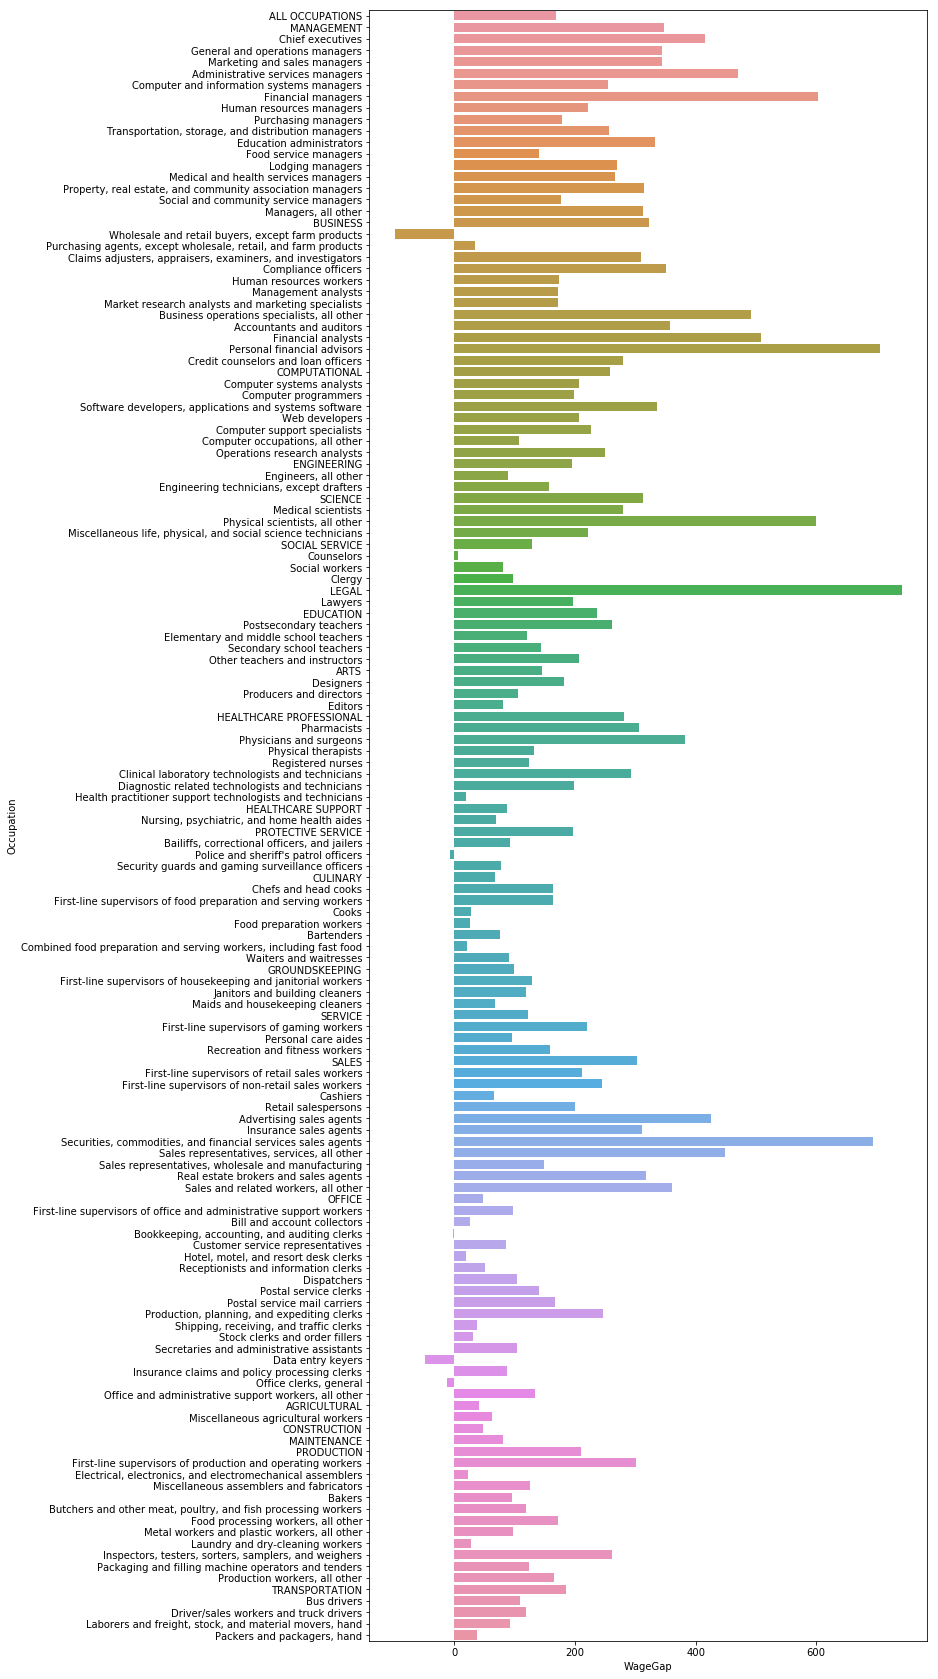

In [65]:
# Lets look at the gap between Men and Women for weekly income
plt.figure(figsize=((10,30)))
sns.barplot(x='WageGap', y='Occupation', data=cleanedgenderwage)
plt.show()

In [ ]:
# make visual of incomes for both genders

In [ ]:
# make visual for gender ratio by occupation

In [ ]:
# make visual for wage gap by occupation

In [ ]:
# make list of all 'Occupation' entries that are all caps, look to be job categories